In [2]:
import pandas as pd
import os
import numpy as np

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling imports
from sklearn import linear_model
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score,precision_recall_curve 
from sklearn.dummy import DummyClassifier

%matplotlib inline
import  warnings
warnings.simplefilter('ignore')

In [3]:
#Reading Fraud Data Set
df_fraud = pd.read_csv("fraud_data.csv",index_col=0)

In [4]:
pd.set_option('display.float_format', lambda x: '%.f' % x)

In [5]:
#Top 5 records - Fraud data set
df_fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
149671,285108,7/15/2015 4:36,9/10/2015 14:17,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2818400139,0
15611,131009,1/24/2015 12:29,4/13/2015 4:53,31,XGQAJSOUJIZCC,SEO,IE,F,21,3251268287,0
73178,328855,3/11/2015 0:54,4/5/2015 12:23,16,VCCTAYDCWKZIY,Direct,IE,M,26,2727760440,0
84546,229053,1/7/2015 13:19,1/9/2015 10:12,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2083419526,0
35978,108439,2/8/2015 21:11,4/9/2015 14:26,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3207912664,0


In [6]:
#Length of Data Set
len(df_fraud)

120000

In [7]:
#Reading IpAddress_to_Country Data Set
df_Ip_Country = pd.read_excel("IpAddress_to_Country.xlsx")

In [8]:
#Top 5 records - LowerIP - UpperIP -Country data set
df_Ip_Country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216,16777471,Australia
1,16777472,16777727,China
2,16777728,16778239,China
3,16778240,16779263,Australia
4,16779264,16781311,China


In [12]:
#length of df_Ip_Country
len(df_Ip_Country)

138846

In [13]:
s = pd.Series(df_Ip_Country['country'].values, pd.IntervalIndex.from_arrays(df_Ip_Country['lower_bound_ip_address'], df_Ip_Country['upper_bound_ip_address']))

In [14]:
df_fraud['country'] = df_fraud['ip_address'].map(s)

In [15]:
# Check for Country value null
df_fraud['country'].isnull().value_counts()

False    102580
True      17420
Name: country, dtype: int64

Here, Fraud Data has 17000 ip addresses with missing country information after mapping with lower and upper boundary ip address data. We can delete ip addresses with missing country info records but there may be a posibility that, these missing ip address corresponds to fake ip addresses generated specifically to create fraud. If it would be the case, We should see some associated correlation. So, for now i am marking these missing country information records "UnKnown"

In [16]:
df_fraud.country.fillna('UnKnown',inplace=True)

In [17]:
# Check null values still exists in Country column
df_fraud[df_fraud['country'].isnull()].country

Series([], Name: country, dtype: object)

No null Values exists - Country column

In [18]:
df_fraud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120000 entries, 149671 to 46646
Data columns (total 12 columns):
user_id           120000 non-null int64
signup_time       120000 non-null object
purchase_time     120000 non-null object
purchase_value    120000 non-null int64
device_id         120000 non-null object
source            120000 non-null object
browser           120000 non-null object
sex               120000 non-null object
age               120000 non-null int64
ip_address        120000 non-null float64
class             120000 non-null int64
country           120000 non-null object
dtypes: float64(1), int64(4), object(7)
memory usage: 11.9+ MB


It seems Fraud Data set looks good with no missing values.

### Exploring Data

##### Summary Statistics

In [19]:
df_fraud.describe(include="all")

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
count,120000,120000,120000,120000,120000,120000,120000,120000,120000,120000,120000,120000
unique,nan,109111,100058,nan,110599,3,5,2,nan,nan,nan,177
top,nan,1/6/2015 12:10,1/6/2015 12:53,nan,ITUMJCKWEYNDD,SEO,Chrome,M,nan,nan,nan,United States
freq,nan,21,20,nan,19,48297,48652,70126,nan,nan,nan,46183
mean,200320,NaN,NaN,37,NaN,NaN,NaN,NaN,33,2151549770,0,NaN
std,115362,NaN,NaN,18,NaN,NaN,NaN,NaN,9,1248314063,0,NaN
min,2,NaN,NaN,9,NaN,NaN,NaN,NaN,18,93447,0,NaN
25%,100926,NaN,NaN,22,NaN,NaN,NaN,NaN,27,1085344808,0,NaN
50%,200038,NaN,NaN,34,NaN,NaN,NaN,NaN,33,2155238209,0,NaN
75%,300396,NaN,NaN,49,NaN,NaN,NaN,NaN,39,3241268072,0,NaN


Above table shows different statistical messures like mean, median and so. 
    1. If we could look at age, it seems good as square root STD (variance), min and Max normally distributed. 
    2. And Fare also looks good.
    
    But to have a clear idea, we can explore more in Data Visualization through Hist and Box plots.

In [20]:
# Check output class is imbalanced or not
df_fraud["class"].value_counts()

0    108735
1     11265
Name: class, dtype: int64

It seems, data set has class imbalance. i.e. 1 in 10 transactions are reported as fraud (around 10% of fraud). So ensemble algorithms performs very well in this kind of scenarios. But let's explore more on this data set and see.

In [21]:
# Check for duplicate entries in data
df_fraud[df_fraud["user_id"].duplicated()==True]

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country


No duplicates in the data, so we are good.

In [22]:
%%time
# Looking for some other useful info by grouping
# We have Signup and Purchase time, it would be usefull if we could calculate time difference. In general if the signup time and purchase time difference is less, that means user creating accounts and purchasing immediately will be a red flag and need to take into consideration.
df_fraud['signup_time'] = df_fraud.signup_time.apply(pd.to_datetime)#pd.to_datetime(df_fraud.signup_time)
df_fraud['purchase_time'] = df_fraud.purchase_time.apply(pd.to_datetime)#pd.to_datetime(df_fraud.purchase_time)

# it is very suspicious if a user signup and then immediately purchase
df_fraud['time_diff'] = (df_fraud.purchase_time - df_fraud.signup_time).apply(lambda x: x.seconds)

Wall time: 1min 37s


In [23]:
df_fraud[df_fraud['time_diff']<=200]['class'].value_counts()

1    6036
0     289
Name: class, dtype: int64

Above data shows almost 95% of fraudlent activities happened when user purchase and signup time difference less (here i have considered as 200 secs - approximately 3 minutes). It is evident that, User signup time and purchase time playing key role in identifying Fraud/Non-Fraud activity. 

In [26]:
# Explore class, sex, age, country, browser, source stats
df_fraud[['class','sex','age','country','browser','source']].groupby(['class','sex','source','browser']).count()

age  country
class sex source browser                
0     F   Ads    Chrome    7184     7184
                 FireFox   2953     2953
                 IE        4466     4466
                 Opera      413      413
                 Safari    2917     2917
          Direct Chrome    3741     3741
                 FireFox   1465     1465
                 IE        2222     2222
                 Opera      218      218
                 Safari    1450     1450
          SEO    Chrome    7370     7370
                 FireFox   2931     2931
                 IE        4414     4414
                 Opera      466      466
                 Safari    3092     3092
      M   Ads    Chrome   10138    10138
                 FireFox   4170     4170
                 IE        6082     6082
                 Opera      660      660
                 Safari    4126     4126
          Direct Chrome    5115     5115
                 FireFox   2067     2067
                 IE        3086     3086
                 Opera      306      306
                 Safari    2011     2011
          SEO    Chrome   10266    10266
                 FireFox   4183     4183
                 IE        6359     6359
                 Opera      640      640
                 Safari    4224     4224
1     F   Ads    Chrome     794      794
                 FireFox    325      325
                 IE         441      441
                 Opera       15       15
                 Safari     218      218
          Direct Chrome     499      499
                 FireFox    135      135
                 IE         194      194
                 Opera       19       19
                 Safari     148      148
          SEO    Chrome     656      656
                 FireFox    339      339
                 IE         382      382
                 Opera       53       53
                 Safari     354      354
      M   Ads    Chrome    1091     1091
                 FireFox    402      402
                 IE         519      519
                 Opera       68       68
                 Safari     479      479
          Direct Chrome     713      713
                 FireFox    206      206
                 IE         383      383
                 Opera       47       47
                 Safari     217      217
          SEO    Chrome    1085     1085
                 FireFox    439      439
                 IE         590      590
                 Opera       70       70
                 Safari     384      384

Above table looks good, as we don't see much imbalance by sex. Sex is not effecting more on Fraud/Non-Fraud activity.
And also, data is dsitributed normally irrespective of Source, Browser. You may see people using using chrome more often than other browsers but it is same across Fraud/Non-Fraud. So i think source won't have much importance in fraud activity.

In [25]:
# Now let's explore Age and class relation, to see if we can find something
pd.crosstab(df_fraud.age,df_fraud['class'])

class,0,1
age,,
18,1987,215
19,2111,199
20,2427,239
21,2752,237
22,2950,301
23,3208,391
24,3538,397
25,3816,327
26,4117,343


If we look at here, age impacts more on transactions (includes Fraud and Non fraud). Trasactions more when you are at young age to mid 30's and then gradually decreases. It is some thing we should take into consideration and apply our transformations on age column.

### Data Visualization

Text(0,0.5,'Frequency')

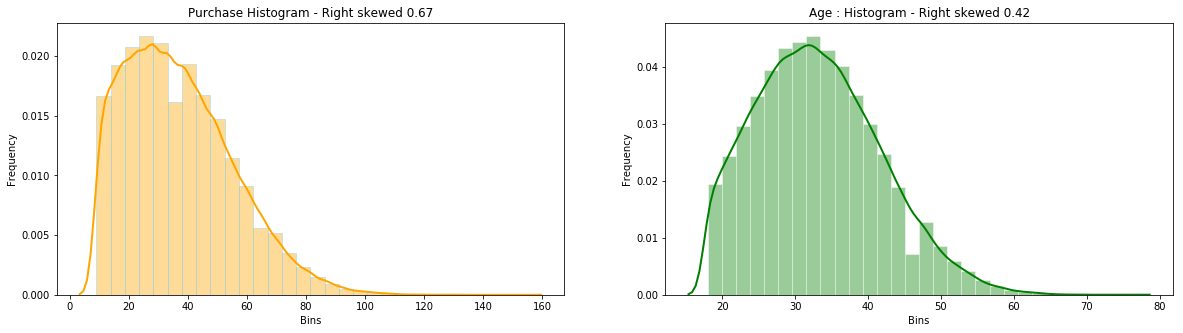

In [27]:
# Look for data distributions of Purchase_value

f, hist_fig=plt.subplots(1,2, figsize=(20,5))

sns.distplot(df_fraud['purchase_value'], hist=True, kde=True, 
             bins=int(30), color = 'orange', 
             hist_kws={'edgecolor':'skyblue'},
             kde_kws={'linewidth': 2}, ax=hist_fig[0])
hist_fig[0].set_title('Purchase Histogram - Right skewed 0.67')
hist_fig[0].set_xlabel('Bins')
hist_fig[0].set_ylabel('Frequency')

sns.distplot(df_fraud.age, hist=True, kde=True, 
             bins=int(30), color = 'green', 
             hist_kws={'edgecolor':'white'},
             kde_kws={'linewidth': 2}, ax=hist_fig[1])
hist_fig[1].set_title('Age : Histogram - Right skewed 0.42')
hist_fig[1].set_xlabel('Bins')
hist_fig[1].set_ylabel('Frequency')


Purchase_value skew is 0.67 and Age skew is 0.42. these both seems right skewed. It would be good if we could see skew as close to as 0. We may have to apply some transformation to have the data, distributed normally. 

In [28]:
# Purchase skew
df_fraud['purchase_value'].skew()

0.6732113033206071

In [29]:
# Age skew
df_fraud.age.skew()

0.42893778637508934

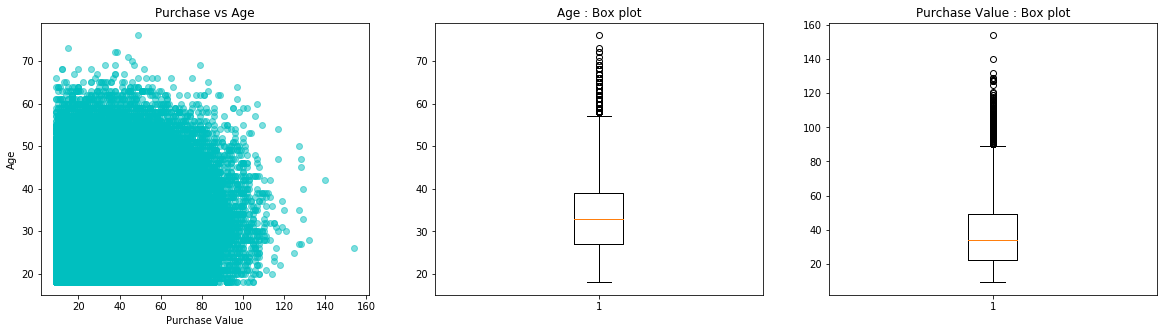

In [30]:
# Age and Purchase value outliers detection

f, sub_fig=plt.subplots(1,3, figsize=(20,5))

sub_fig[0].scatter(df_fraud['purchase_value'],df_fraud.age,c='c', alpha=0.5)
sub_fig[0].set_title('Purchase vs Age')
sub_fig[0].set_xlabel('Purchase Value')
sub_fig[0].set_ylabel('Age')

sub_fig[1].boxplot(df_fraud.age)
sub_fig[1].set_title('Age : Box plot')

sub_fig[2].boxplot(df_fraud['purchase_value'])
sub_fig[2].set_title('Purchase Value : Box plot')

plt.tight_layout
plt.show()

It seems Age and Purchase value has outliers, It would be better if we could apply feature engineering to seperate data into bins. Otherwise it may effect our model performance.

In [31]:
# Initialize a temp data frame and look for some relations of device ids shared, ip address shared, signup time, day, week. 
# If we find any relation then we can apply to main data frame feature engineering.
tmp_df = pd.DataFrame(columns=("class", "userids_per_deviceid", "userids_per_ipaddress"))
tmp_df["class"] = df_fraud["class"]

# Count the number of unique user ids associated each device
userid_count = df_fraud.groupby("device_id").user_id.count()
tmp_df["userids_per_deviceid"] = df_fraud.device_id.apply(lambda x: userid_count[x])

# Count the number of unique user ids associated each ip address
userid_count = df_fraud.groupby("ip_address").user_id.count()
tmp_df["userids_per_ipaddress"] = df_fraud.ip_address.apply(lambda x: userid_count[x])

# day of the week
tmp_df['signup_time_dow'] = pd.to_datetime(df_fraud['signup_time']).dt.dayofweek
tmp_df['purchase_time_dow'] = pd.to_datetime(df_fraud['purchase_time']).dt.dayofweek
# week of the year
tmp_df['signup_time_week'] = pd.to_datetime(df_fraud['signup_time']).dt.week
tmp_df['purchase_time_week'] = pd.to_datetime(df_fraud['purchase_time']).dt.week

tmp_df['signup_hour_of_day'] = pd.to_datetime(df_fraud['purchase_time']).dt.hour
tmp_df['purchase_hour_of_day'] = pd.to_datetime(df_fraud['signup_time']).dt.hour


In [32]:
tmp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120000 entries, 149671 to 46646
Data columns (total 9 columns):
class                    120000 non-null int64
userids_per_deviceid     120000 non-null int64
userids_per_ipaddress    120000 non-null int64
signup_time_dow          120000 non-null int64
purchase_time_dow        120000 non-null int64
signup_time_week         120000 non-null int64
purchase_time_week       120000 non-null int64
signup_hour_of_day       120000 non-null int64
purchase_hour_of_day     120000 non-null int64
dtypes: int64(9)
memory usage: 9.2 MB


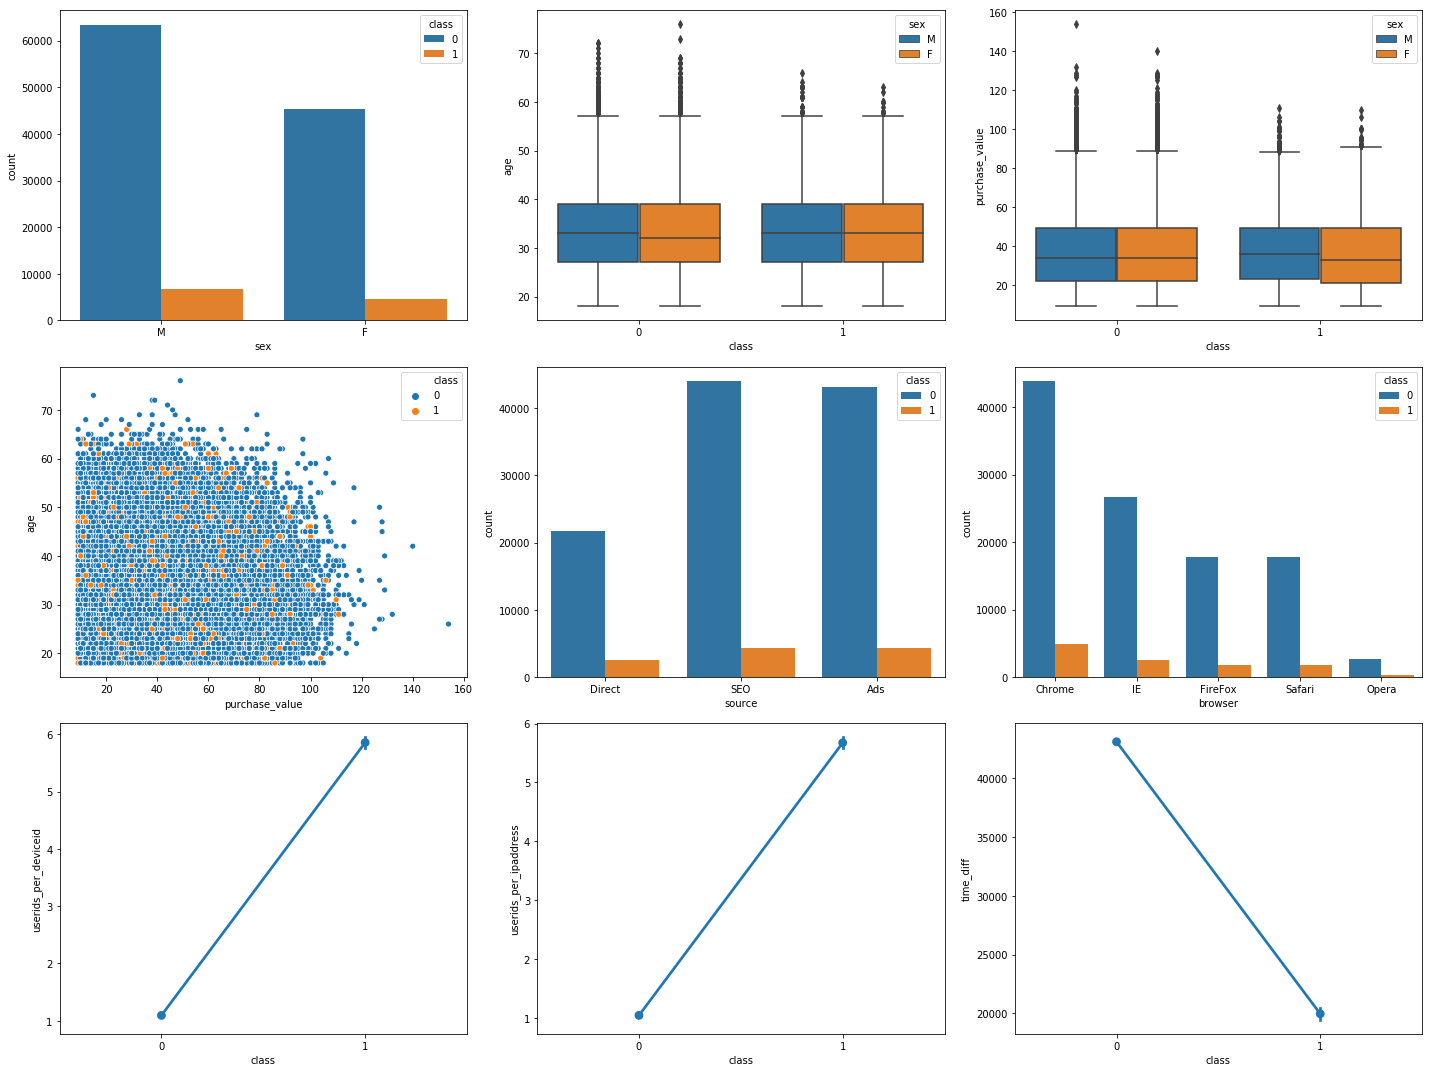

In [34]:
# EXploring little more on age, Purchse value, class, browser, source, deviceids shared, ipaddress shared
f, rel_fig=plt.subplots(3,3, figsize=(20,15))

sns.countplot(x='sex', hue='class', data=df_fraud,ax=rel_fig[0,0])

sns.catplot(x="class", y="age", kind="box", hue='sex', data=df_fraud, ax=rel_fig[0,1]);

sns.catplot(x="class", y="purchase_value", kind="box", hue='sex', data=df_fraud, ax=rel_fig[0,2]);

#sns.catplot(x="class", y="purchase_value", kind="box", hue='sex', data=df_fraud, ax=rel_fig[1,0]);

sns.scatterplot(x="purchase_value", y="age", hue="class", data=df_fraud, ax=rel_fig[1,0]);

sns.countplot(x='source', hue='class', data=df_fraud,ax=rel_fig[1,1])

sns.countplot(x='browser', hue='class', data=df_fraud,ax=rel_fig[1,2])

sns.factorplot(x="class", y="userids_per_deviceid", data=tmp_df, ax=rel_fig[2,0])

sns.factorplot(x="class", y="userids_per_ipaddress", data=tmp_df, ax=rel_fig[2,1])

h=sns.factorplot(x="class", y="time_diff", data=df_fraud, ax=rel_fig[2,2])

plt.close(2)
plt.close(3)
plt.close(4)
plt.close(5)
plt.close(6)
plt.tight_layout()
plt.show()

If we look above diagrams, 

1. Figure 1 - It exaplins the relation between sex and class. Males make up more of the customer base of the company and thus are also involved in more of the fraud cases. It doesn't look like one gender is more likely to participate in fraud though, just that one gender tends to use the site more in general.
2. Figure 2, 3 - It explains outliers in Age and purchase values. Here we can see more outliers in exists in Age and Purchase value. It would be better if we could apply feature engineering to seperate the data into bins, so that outlier will be reduced and our model will give better performance.
3. Figure 4 - It explains the relationship between purchase value, age, fraud. It doesn't look like purchase value and gender is not effecting more fraudlent activity.
4. Figure 5 - It explains the relationship between marketing source and fraud. It doesn't look like any given marketing source is more associated with fraud either. Although there are less direct sources associated with fraud and there are less direct sources overall (fraud and non-fraud) aswell.
5. Figure 6 - It explains the relationship between browser used and fraud. Here, user more towards chrome browser but this not effecting anything on fraud/non-fraud activity. 
6. Figure 7,8 - It explains the relationship between the number of unique user ids assocated with either a single device or a single ip address. These are clearly important correlations. Here it seems that multiple user ids associated with either a unique device id or ip address is a large indicator of fraudulent behaviour.
7. Figure 9 - It explains the relationship between the time between sign-up and purchase and fraud. Here small time periods between sign-up and purchase are also strongly impact the fraud.


Explore in detail on Sign up and Purchase time to find little more relation

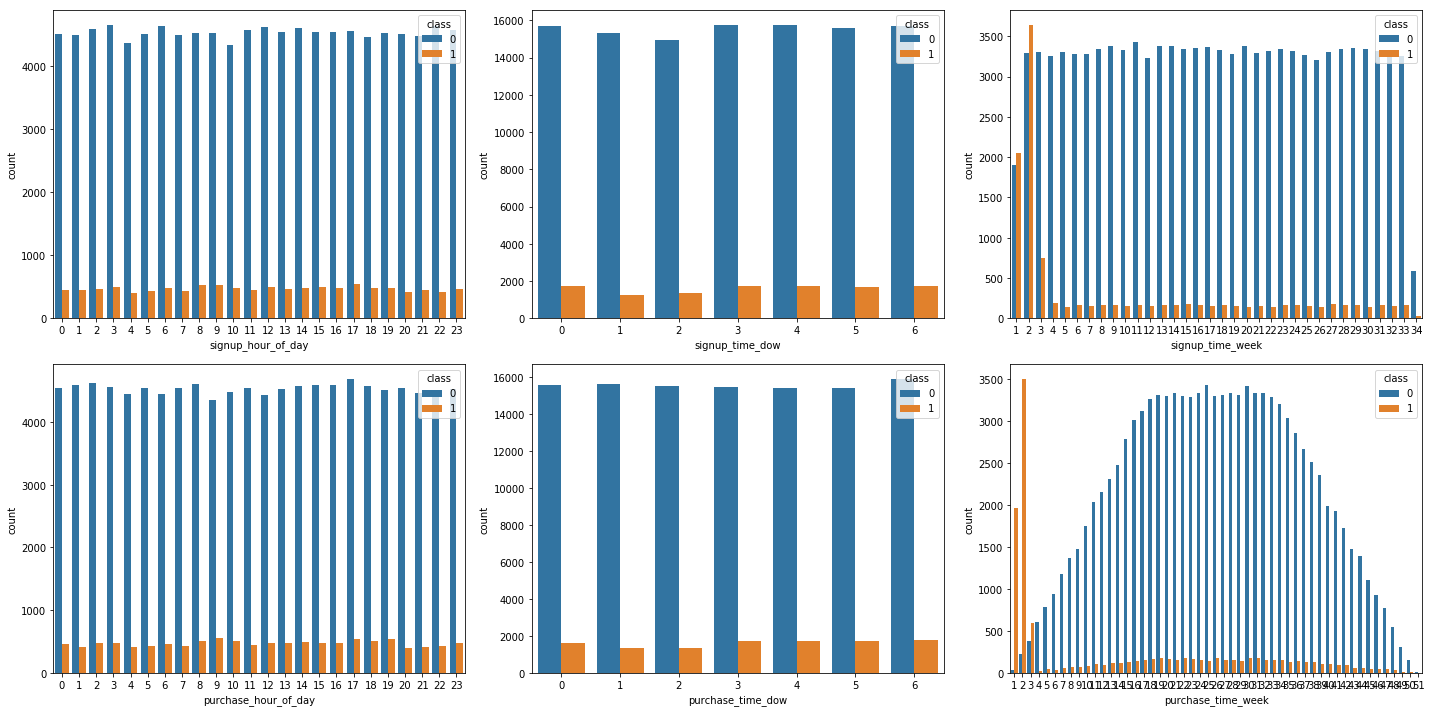

In [35]:
f, time_fig=plt.subplots(2,3, figsize=(20,10))

sns.countplot(x='signup_hour_of_day', hue='class', data=tmp_df, ax=time_fig[0,0])
sns.countplot(x='signup_time_dow', hue='class', data=tmp_df, ax=time_fig[0,1])
sns.countplot(x='signup_time_week', hue='class', data=tmp_df, ax=time_fig[0,2])

sns.countplot(x='purchase_hour_of_day', hue='class', data=tmp_df, ax=time_fig[1,0])
sns.countplot(x='purchase_time_dow', hue='class', data=tmp_df, ax=time_fig[1,1])
sns.countplot(x='purchase_time_week', hue='class', data=tmp_df, ax=time_fig[1,2])

plt.close(2)
plt.close(3)
plt.tight_layout()
plt.show()


When we look at above diagrams, Explains the relationship between purchase time, Signup time (hour of the day, day of the week, week of the year) and fraud. It looks like fraud occurs pretty regularly throughout the hours of the day and days of the week. I don't think there is something unsual we see here, irrespective fo time fraud occuring.
However, there big spikes of fraud in starting of the year.

This insight will be helpfulto  alert the organization for fraud during the first three weeks of the year.

#### Feature Engineering

Here, I'll list all the new features that I'll add in this section.

1. Multiple user ids for a unique device/ip address  - As we have seen clearly very good indicator of identifying fraud
2. Time diff between sign-up and purchase in seconds - It has already added to our data set
3. We have seen Age column outliers and it has right skewed. It would be better if we could apply some binning transformation, so that model understand range of Ages very well rather than individual vlaues impact and to distribute the data normally.
4. Also we have outliers in Purchase value column, few transactions have very high transaction amount. It would be better if we could apply some binning here.
5. One-hot-encoded features for each country

In [36]:
# Count the number of unique user ids associated each device
df_fraud['userids_per_ipaddress'] = df_fraud.groupby('ip_address')['user_id'].transform('count')

# Count the number of unique user ids associated each ip address
df_fraud['userids_per_deviceid'] = df_fraud.groupby('device_id')['user_id'].transform('count')

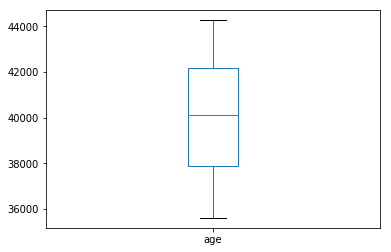

In [37]:
# Applying binning to reduce outliers
pd.qcut(df_fraud.age,3,labels=['18-30Age','30-50Age','41+']).value_counts().plot(kind='box')

In [38]:
# Adding age_bin transformation to df_fraud data frame
df_fraud['age_bin']= pd.qcut(df_fraud.age,3,labels=['Age18-30','Age30-50','Age41+'])

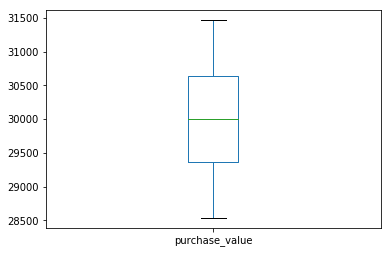

In [39]:
# Applying binning to purchase_value to reduce outliers
pd.qcut(df_fraud['purchase_value'],4,labels=['low','medium','high','very_high']).value_counts().plot(kind='box')

In [40]:
# Adding purchase_bin transformation to df_fraud data frame
df_fraud['purchase_bin']=pd.qcut(df_fraud['purchase_value'],4,labels=['low','medium','high','very_high'])#.value_counts().plot(kind='box')

In [41]:
df_fraud.head(2)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,userids_per_ipaddress,userids_per_deviceid,age_bin,purchase_bin
149671,285108,2015-07-15 04:36:00,2015-09-10 14:17:00,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2818400139,0,United States,34860,1,2,Age41+,medium
15611,131009,2015-01-24 12:29:00,2015-04-13 04:53:00,31,XGQAJSOUJIZCC,SEO,IE,F,21,3251268287,0,United Kingdom,59040,1,1,Age18-30,medium


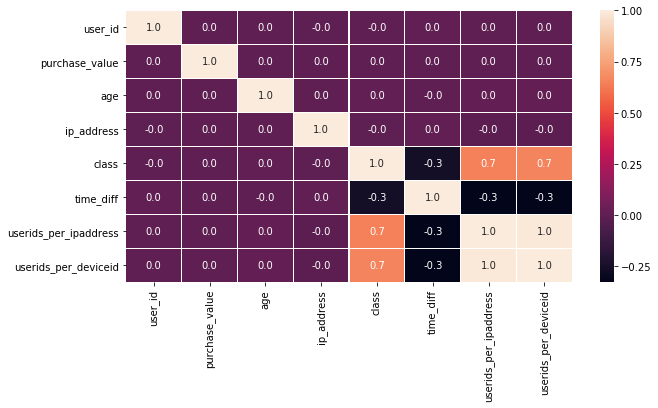

In [42]:
# Find Feature correlation using heat map

f,ax = plt.subplots(figsize=(10, 5))
sns.heatmap(df_fraud.corr(), annot=True, linewidths=.1, fmt= '.1f',ax=ax)

If we look at here, userids_per_deviceid and userids_per_ipaddress strongly correlate each other. So instead of considering only one feature we can take mean of two features. If we consider only one feature (either by ipaddress or deviceid), there is a possibility to miss the info by ipaddress or by deviceid. So taking mean of these might help in achieving this.

In [43]:
# Add column for the average of the userids_per_deviceid,userids_per_ipaddress
df_fraud["mean_number_of_ip_device_userids"] = (df_fraud.userids_per_deviceid + df_fraud.userids_per_ipaddress) * 0.5

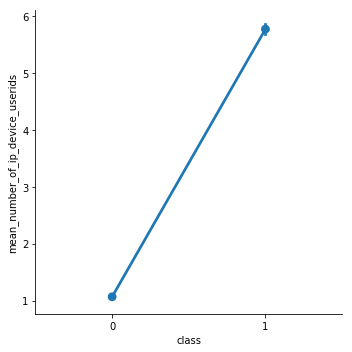

In [44]:
sns.factorplot(x="class", y="mean_number_of_ip_device_userids", data=df_fraud)

#### Categorical Feature Encoding

now, we can have cleaned data frame with necessary columns.
1. User_id field is not required, as we have created new feature mean of ip_device_userids
2. Signup and Purchase time fields are not required, as we have created new feature on this 'Time_Diff'
3. Purchase_Value column is not required, as we have created new feature 'Purchase_bin' as part of outlier treatment
4. Device id not required as we have created new feature mean of ip_device_userids
5. Age column not required as we have created new feature 'age_bin'
6. ip_address column not required as we have created new feature mean of ip_device_userids
7. userids_per_deviceid, userids_per_ipaddress is not required as we have created new feature mean_number_of_ip_device_userids
8. And required column list,
   col_list = ['source','browser','sex','age_bin','purchase_bin','country','time_diff','mean_number_of_ip_device_userids','class']

In [45]:
col_list = ['source','browser','sex','age_bin','purchase_bin','country','time_diff','mean_number_of_ip_device_userids','class']
df_fraud = df_fraud[col_list]
df_fraud.head(2)

,source,browser,sex,age_bin,purchase_bin,country,time_diff,mean_number_of_ip_device_userids,class
149671,Direct,Chrome,M,Age41+,medium,United States,34860,2,0
15611,SEO,IE,F,Age18-30,medium,United Kingdom,59040,1,0


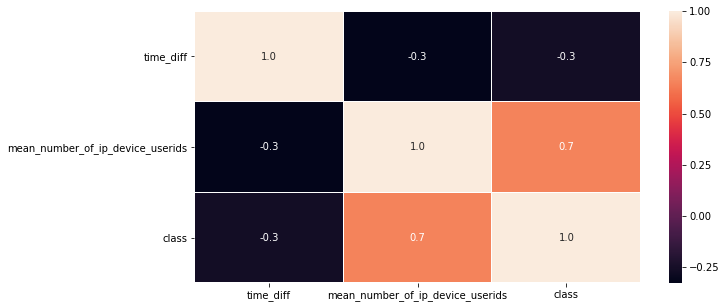

In [46]:
f,ax = plt.subplots(figsize=(10, 5))
sns.heatmap(df_fraud.corr(), annot=True, linewidths=.1, fmt= '.1f',ax=ax)

In [47]:
# create dummy variables for categorical features - onehot encoding
final_fraud = pd.get_dummies(df_fraud,['source','browser','sex','age_bin','purchase_bin','country'])
final_fraud.head()

,time_diff,mean_number_of_ip_device_userids,class,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,...,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe
149671,34860,2,0,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
15611,59040,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
73178,41340,1,0,0,1,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
84546,75180,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35978,62100,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Here I am trying to know feature importance using ExtratreesClassifier

In [51]:
# Data Set with no class feature
X = final_fraud[ [col for col in final_fraud.columns if col != "class"] ]

# Data set with only class feature
Y = final_fraud["class"]

In [49]:
model = ExtraTreesClassifier()
model.fit(X, Y)
feature_imp=model.feature_importances_
print(feature_imp)

[4.44498282e-01 4.08184761e-01 3.28225991e-03 1.65856413e-03
 3.26417598e-03 6.56733891e-03 5.54668870e-03 6.06876827e-03
 2.62820363e-03 5.76442253e-03 6.00183648e-03 5.66711363e-03
 6.65488932e-03 5.10793198e-03 5.57254166e-03 6.11867160e-03
 6.93753991e-03 6.76253575e-03 6.03759817e-03 5.78128872e-05
 4.41851731e-06 3.87946820e-04 4.95232292e-05 2.55549585e-07
 1.01566736e-03 1.15336541e-04 1.37162909e-03 6.31329212e-04
 7.19223311e-05 2.03017299e-07 2.39300587e-06 1.00187988e-04
 2.80714605e-06 9.06999162e-05 7.16268580e-04 5.62073105e-07
 7.98976025e-08 8.77744353e-08 2.19303386e-07 1.57789478e-04
 7.41231005e-05 3.63067729e-06 1.72071391e-03 7.05160437e-08
 1.80242476e-06 1.07347912e-04 1.76730673e-07 1.52928665e-06
 7.35662349e-07 1.60796350e-03 9.02683449e-08 3.70186261e-07
 6.22330710e-04 3.20632424e-03 7.78401746e-04 1.49071358e-06
 1.98404892e-06 1.66008542e-04 3.86354157e-07 1.95626094e-04
 8.95323119e-07 9.98704534e-07 3.94719053e-05 3.16537241e-04
 5.42150836e-04 4.555374

Seems all the features are important. The greater score means greater the importance.

In [50]:
final_fraud.head(2)

,time_diff,mean_number_of_ip_device_userids,class,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,...,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe
149671,34860,2,0,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
15611,59040,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Build ML model and Evaluate

In [52]:
print (X.shape, Y.shape)

(120000, 196) (120000,)


In [53]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=1)

In [54]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96000 entries, 126610 to 3801
Columns: 196 entries, time_diff to country_Zimbabwe
dtypes: float64(1), int64(1), uint8(194)
memory usage: 20.0 MB


In [55]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24000 entries, 64601 to 150000
Columns: 196 entries, time_diff to country_Zimbabwe
dtypes: float64(1), int64(1), uint8(194)
memory usage: 5.0 MB


In [57]:
np.mean(Y_train)

0.09384375

In [58]:
np.mean(Y_test)

0.094

Here, it would be good if we could build baseline model with no machine learning model and compare in later point. It will be helpfull to compare our ML model is performing better than base line model or not? Baseline model always gives output of majority class. Predictive model should beat the baseline model performance.

#### Baseline model

In [59]:
model_dummy = DummyClassifier(strategy='most_frequent',random_state=0)
model_dummy.fit(X_train,Y_train)
print('score for baseline model: {0:.2f}'.format(model_dummy.score(X_test,Y_test)))
# Performance Metrics
print('accuracy for Baseline model: {0:.2f}'.format(accuracy_score(Y_test,model_dummy.predict(X_test))))

# Confusion Matrix
print('Confusion matrix for Baseline model: \n {0}'.format(confusion_matrix(Y_test,model_dummy.predict(X_test))))

# Precision and Recall scores
print('Precision for baseline Model: {0:.2f}'.format(precision_score(Y_test, model_dummy.predict(X_test))))
print('Recall for baseline Model: {0:.2f}'.format(recall_score(Y_test, model_dummy.predict(X_test))))

score for baseline model: 0.91
accuracy for Baseline model: 0.91
Confusion matrix for Baseline model: 
 [[21744     0]
 [ 2256     0]]
Precision for baseline Model: 0.00
Recall for baseline Model: 0.00


Ensemble Algorithms works well when we have class imbalance in target variable. First we can explore with Random Forest and then GBM (Gradient Boosting).

In [61]:
# Traning the model
rf = RandomForestClassifier()
rf_model = rf.fit(X_train, Y_train)

# Predicting the results
y_pred = rf_model.predict(X_test)

In [62]:
rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [63]:
# Evaluating
model_test_score = rf_model.score(X_test,Y_test)
conf_matrix = confusion_matrix(Y_test, y_pred)
print ('MODEL TEST SCORE: {0:.5f}'.format(model_test_score))
print("ACCURACY: {0:.2f}".format(accuracy_score(Y_test, y_pred)))
print("ROC-AUC: {0:.2f}".format(roc_auc_score(Y_test, y_pred)))
print("PRECISION: {0:.2f}".format(precision_score(Y_test, y_pred)))
print("RECALL: {0:.2f}".format(recall_score(Y_test, y_pred)))
print("Confusion Matrix:\n",conf_matrix)
print ('\nTrue Negatives: ', conf_matrix[0,0])
print ('False Negatives: ', conf_matrix[1,0])
print ('True Positives: ', conf_matrix[1,1])
print ('False Positives: ', conf_matrix[0,1])

MODEL TEST SCORE: 0.94117
ACCURACY: 0.94
ROC-AUC: 0.77
PRECISION: 0.76
RECALL: 0.55
Confusion Matrix:
 [[21350   394]
 [ 1018  1238]]

True Negatives:  21350
False Negatives:  1018
True Positives:  1238
False Positives:  394


When we see above scores, Accuracy is 94% as a first check we beat the baseline accuracy 91%. It's good sign. Now we need to look at Precision and Recall. In classification imbalance problems we should not depend on only accuracy, we need to take precision and recall into consideration. We see that our random forest model is very precise, meaning that all the ones it flags as positive (fraudulent) are likely to be actual fraudulent transactions(75%).

Our recall, on the other hand, is not quite as good, just above 50%. This means the model will capture 55% of % of the total correct(positive) items correctly predicted by the model.

Before plotting AUC-ROC for our random forest model, we can fit another ensemble algorithm XGboost.

### XGBoost classifier

In [64]:
xgb = XGBClassifier()

# Fitting the model
xgb_model = xgb.fit(X_train, Y_train)

# Predicting results
y_pred = xgb_model.predict(X_test)

In [65]:
model_train_score = xgb_model.score(X_train,Y_train)
model_test_score = xgb_model.score(X_test,Y_test)
conf_matrix = confusion_matrix(Y_test, y_pred)
print ('MODEL TEST SCORE: {0:.5f}'.format(model_train_score))
print ('MODEL TEST SCORE: {0:.5f}'.format(model_test_score))
print("ACCURACY: {0:.2f}".format(accuracy_score(Y_test, y_pred)))
print("ROC-AUC: {0:.2f}".format(roc_auc_score(Y_test, y_pred)))
print("PRECISION: {0:.2f}".format(precision_score(Y_test, y_pred)))
print("RECALL: {0:.2f}".format(recall_score(Y_test, y_pred)))
print("Confusion Matrix:\n",conf_matrix)
print ('\nTrue Negatives: ', conf_matrix[0,0])
print ('False Negatives: ', conf_matrix[1,0])
print ('True Positives: ', conf_matrix[1,1])
print ('False Positives: ', conf_matrix[0,1])

MODEL TEST SCORE: 0.95640
MODEL TEST SCORE: 0.95592
ACCURACY: 0.96
ROC-AUC: 0.77
PRECISION: 1.00
RECALL: 0.53
Confusion Matrix:
 [[21744     0]
 [ 1058  1198]]

True Negatives:  21744
False Negatives:  1058
True Positives:  1198
False Positives:  0


When we see above scores, Accuracy is 96% as a first check we beat the baseline accuracy 91%. Now we need to look at Precision and Recall. 

Precision - Precision goal is to minimize number of False positives. Here Precision is 1. It looks very good. It seems number of non-fraud transactions classified as fraud is zero. The False positives are zero is one of the very good sign when we consider about non-fraud classifying as fraud. In our case it is necessary as a cost incurred at 8$ if model flagged as fraud for non-fraud transactions.

Recall - How often positive result be predicted correctly. Here recall is not quite as good, just above 50%(53%). It would be considered to minimize numnber of False Negatives. Here number of fraud transactions classified as non-fraud is high chance as we have very less recall. False negatives need to take care as we may see issue of marking fraud transactions are non-fraud.

XGboost giving good results compared with Random Forest. For now, i will choose this model and fine tune to see if i can improve performance of model any further.

#### Plotting AUC-ROC

Here goal is to balance False positive and False Negatives. Lets draw ROC curve between TPR - True Positive Rate (Recall), FPR - False Positive Rate(1-Specifity)

In [66]:
y_predd=xgb_model.predict_proba(X_test)

In [67]:
def plot_validation_roc():
    fpr,tpr,thresholds = roc_curve(Y_test,y_predd[:,1])
    return pd.DataFrame({'FPR':fpr,'TPR':tpr,'Threshold':thresholds})

In [68]:
p=plot_validation_roc()

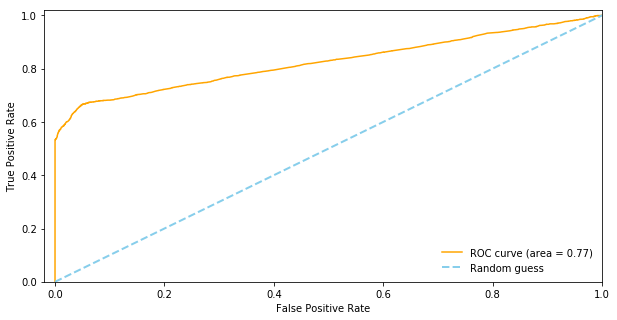

In [69]:
roc_auc = roc_auc_score(Y_test, y_pred)
plt.figure(figsize=(10,5))
plt.plot(p.FPR,p.TPR, color='orange', label='ROC curve (area = %0.2f)'%roc_auc)
plt.xlim([-0.02, 1])
plt.ylim([0, 1.02])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0, 1], [0, 1], color='skyblue', lw=2, linestyle='--',label='Random guess')
plt.legend(loc="lower right",frameon=False)

In [70]:
print(classification_report(Y_test, y_pred))

             precision    recall  f1-score   support

          0       0.95      1.00      0.98     21744
          1       1.00      0.53      0.69      2256

avg / total       0.96      0.96      0.95     24000



#### Impact False Positives and False Negatives

in this case, because normally this "Fraud Detection Model" is often used in a pre-screening step.

If 'Fraud' is classified as 'Not Fraud' is more cost than non fraud classifying as fraud.The company will lose money directly.
so in this case, "false negative" cost much higher, so we should choose a relatively smaller threshold.

##### Precision Recall trade-off

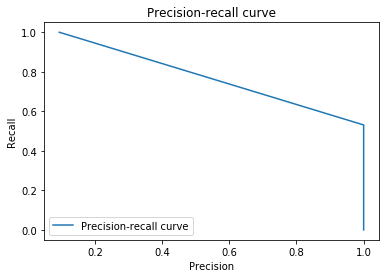

In [73]:
precision, recall, thresholds = precision_recall_curve(Y_test, y_pred)
# create plot
plt.plot(precision, recall, label='Precision-recall curve')
_ = plt.xlabel('Precision')
_ = plt.ylabel('Recall')
_ = plt.title('Precision-recall curve')
_ = plt.legend(loc="lower left")

Now we need to improve our model performance by reducing False Negatives. Generally ensemble algorithms more prone to overfitting, to reduce this we can add regularization term. For this we can apply hyper parameter tuning using crossvalidation techniques (K - fold cross validation).

### Tuning Model

Fine tuning a model especially ensemble model is very huge process and requires lot of time. For now i will try to explore little more to see if i can fine tune this model. Now in order to decide on boosting parameters, we need to set some initial values of other parameters. Lets take the following values:

1. max_depth = 6 : This should be between 3-10. I’ve started with 5 but you can choose a different number as well. 4-6 can be good starting points.
2. subsample, colsample_bytree = 0.8 : This is a commonly used used start value. Typical values range between 0.5-0.9.
3. learning_rate = 0.05

In [74]:
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
             'objective':['binary:logistic'],
             'learning_rate': [0.05], #so called `eta` value
             'max_depth': [6],
             'subsample': [0.8],
             'colsample_bytree': [0.7],
             'n_estimators': [5], #number of trees, change it to 1000 for better results
             'missing':[-999],
             'seed': [1337]}

In [75]:
clf = GridSearchCV(xgb_model, parameters, n_jobs=5, 
                   cv=3, 
                   scoring='roc_auc',
                   verbose=2, refit=True)

In [76]:
clf.fit(X_train, Y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=5)]: Done   3 out of   3 | elapsed:   26.5s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=5,
       param_grid={'nthread': [4], 'objective': ['binary:logistic'], 'learning_rate': [0.05], 'max_depth': [6], 'subsample': [0.8], 'colsample_bytree': [0.7], 'n_estimators': [5], 'missing': [-999], 'seed': [1337]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

In [77]:
best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
print('Raw AUC score:', score)
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

Raw AUC score: 0.8303421469611075
colsample_bytree: 0.7
learning_rate: 0.05
max_depth: 6
missing: -999
n_estimators: 5
nthread: 4
objective: 'binary:logistic'
seed: 1337
subsample: 0.8


In [78]:
tune_pd=clf.predict(X_test)

In [79]:
model_tune_test_score = clf.score(X_test,Y_test)
conf_tune_matrix = confusion_matrix(Y_test, tune_pd)
print ('MODEL TEST SCORE: {0:.5f}'.format(model_tune_test_score))
print("ACCURACY: {0:.2f}".format(accuracy_score(Y_test, tune_pd)))
print("ROC-AUC: {0:.2f}".format(roc_auc_score(Y_test, tune_pd)))
print("PRECISION: {0:.2f}".format(precision_score(Y_test, tune_pd)))
print("RECALL: {0:.2f}".format(recall_score(Y_test, tune_pd)))
print("Confusion Matrix:\n",conf_tune_matrix)
print ('\nTrue Negatives: ', conf_tune_matrix[0,0])
print ('False Negatives: ', conf_tune_matrix[1,0])
print ('True Positives: ', conf_tune_matrix[1,1])
print ('False Positives: ', conf_tune_matrix[0,1])

MODEL TEST SCORE: 0.82764
ACCURACY: 0.96
ROC-AUC: 0.77
PRECISION: 1.00
RECALL: 0.53
Confusion Matrix:
 [[21744     0]
 [ 1058  1198]]

True Negatives:  21744
False Negatives:  1058
True Positives:  1198
False Positives:  0


With new parameters, still it giving almost same as generalized parameters of XGB model. Here we can apply K-fold cross validation using grid search CV to find best possible parameters. But it needs lots time to process. For now i am not going in detail.

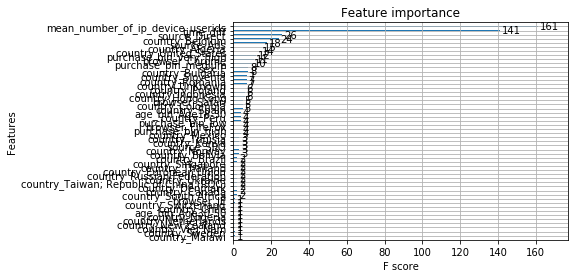

In [80]:
# Also looking at original xgb model feature importances.
plot_importance(xgb_model)
plt.show()

Above shows Features importance. I know images looks ugly, but i have around 190 features.

In [82]:
thresholds=np.sort(xgb_model.feature_importances_)

Below one shows, feature standardization using SelectFromModel.

In [83]:
for thresh in thresholds[thresholds>0]:
    # select features using threshold
    selection = SelectFromModel(xgb_model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, Y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_select_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_select_pred]
    accuracy = accuracy_score(Y_test, predictions)
    precision_s = precision_score(Y_test, predictions)
    recall_s = recall_score(Y_test, predictions)
    roc_auc_s = roc_auc_score(Y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%, Precision: %.2f%%, Recall: %.2f%%, ROC_AUC_Score: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0, precision_s*100.0, recall_s*100.0, roc_auc_s*100.0))

Thresh=0.002, n=52, Accuracy: 95.59%, Precision: 100.00%, Recall: 53.10%, ROC_AUC_Score: 76.55%
Thresh=0.002, n=52, Accuracy: 95.59%, Precision: 100.00%, Recall: 53.10%, ROC_AUC_Score: 76.55%
Thresh=0.002, n=52, Accuracy: 95.59%, Precision: 100.00%, Recall: 53.10%, ROC_AUC_Score: 76.55%
Thresh=0.002, n=52, Accuracy: 95.59%, Precision: 100.00%, Recall: 53.10%, ROC_AUC_Score: 76.55%
Thresh=0.002, n=52, Accuracy: 95.59%, Precision: 100.00%, Recall: 53.10%, ROC_AUC_Score: 76.55%
Thresh=0.002, n=52, Accuracy: 95.59%, Precision: 100.00%, Recall: 53.10%, ROC_AUC_Score: 76.55%
Thresh=0.002, n=52, Accuracy: 95.59%, Precision: 100.00%, Recall: 53.10%, ROC_AUC_Score: 76.55%
Thresh=0.002, n=52, Accuracy: 95.59%, Precision: 100.00%, Recall: 53.10%, ROC_AUC_Score: 76.55%
Thresh=0.002, n=52, Accuracy: 95.59%, Precision: 100.00%, Recall: 53.10%, ROC_AUC_Score: 76.55%
Thresh=0.002, n=52, Accuracy: 95.59%, Precision: 100.00%, Recall: 53.10%, ROC_AUC_Score: 76.55%
Thresh=0.004, n=42, Accuracy: 95.59%, Pr

If we could see above results, when n=7(number of features), and Threshold = 0.025, then Accuracy went to 95.60% and Recall, ROC_Auc score slightly higher than other values.

### Conclusion and Recommendations
From the random forest and gradient boosting classifier models we can make the following inferences and conclusions from the data.

1. There are 4 important features that determine whether or not a transaction is fradulent. They are in the order of coefficient weights, the following: 'time_diff' (shopping time), 'mean deviceid count', Age,Sex.

2. shopping time turns out to the the single most important feature in predicting fraudulent transactions. In fact, many of the fraudulent transactions have shopping time of less, meaning used some automated software to made the purchase.

3. Mean number of userids - device_id_count and ip_address_count also are important aspects of a fradulent transaction, as fraud attempting are likely to buy certain items in fraudulent transactions and use the same ip address.

4. Age and Sex also effecting.

5. Other features did not have significant enough correlation with fraudulent transactions. Country of origin did not matter, and other categorical features like browser, source, etc were not important.

From these inferences from the data and the model, we can make the following business recommendations about fraudulent transactions and how to implement this model from a product perspective.


Here the best part is False positives zero, it means identifying real transaction as fraud is very rare. So each transaction 8$ commision will be saved. We need to concentrate on false negatives. To do this, Have the company's e-commerce website continuously calculate the fraudulent transaction probability with the user's inputs when buying the product. And if the risk of fraudulent transaction is greater than some threshold value, the website can ask the user to verify additional information or hold the transaction and flag it for further review.
For example, the transaction can be divided into 3 categories:

1. If predicted fraud probability is small, then the normal transaction can take place with the user.
2. If the predicted fraud probabilty is medium, then the website will ask the user for additional verification. This can be some code sent to the user via his email or phone, or similar check.
3. Finally, if the predicted fraud probability is high, then the website will put the transaction on hold and notify the user that the purchase is under review. If found to be fraudulent, then the website will block the user and his IP address.
